# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения 
    * SGD+momentum, Adam
    
Адрес для посылки ДЗ mfti_2018_hw03@mail.ru

# Требуемые модули:
Python 3.6
1. pytorch=0.41 // [инструкция по установке](https://pytorch.org/get-started/previous-versions/)
2. torchvision=0.2.2.post3 // pip install ...
3. matplotlib  //
4. PIL=5.4.1
5. scipy=1.1.0
6. numpy=1.15.14
7. pickle

# Требования
1. Присылаем этот ноутбук только с полностью выполненными заданиями.
2. Файл должен называть MFTI_2019_hw03_ФАМИЛИЯ_ИМЯ.ipynb
3. Заданние должно быть выполнено до 24.03.2019 до 23:59.
4. После проверки у Вас будет одна попытка для исправления замечаний. 

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку <font collor='red'>__pytorch__</font>. Получаем на вход тензор размером $(C_{in}, H, W)$, на выходе получаем тензор $(C_{out}, H_{out}, W_{out})$.
$$
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки с параметрами:

$\large k $ - ядро свертки, тензор с парамерами $C_{in}, H_k, W_k,$ <br>
$stride_{H,W}$ - шаг ядра свертки, <br>
$padding_{H,W} $ - размер паддинга.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда
    :param  padding:  tuple - параметры паддинга
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
#     pass
    x =  x.unsqueeze(0)
    count_batch, count_C, count_H,count_W = x.shape
    
    kernel_h,kernel_w= kernel.shape[1::]
    n_C = kernel.size()[0]
    
    new_H = int((count_H + 2*padding[0] - kernel_h) / stride[0] + 1)
    new_W = int((count_W + 2*padding[1] - kernel_w) / stride[1] + 1)
    
    Out = torch.zeros(count_batch, new_H, new_W)
    X_with_pad=torch.zeros(count_batch,count_C,count_H+2*padding[0],count_W+2*padding[1])
    X_with_pad[:,:,padding[0]:count_H+padding[0],padding[1]:padding[1]+count_W]=x
    bias=0 if bias==None else bias
    for i in range(count_batch):                                      
        x_with_pad = X_with_pad[i, :] 
        for h in range(new_H):                                   
            for w in range(new_W):                                                      

                up = h * stride[0]
                down = h * stride[0] + kernel_h
                left = w * stride[1]
                right = w * stride[1] + kernel_w
                    
                part = x_with_pad[:, up : down ,left : right]  
#                 l=torch.sum(torch.mul(part,kernel))#+bias
                Out[i, h, w] = torch.sum(torch.mul(part,kernel))+bias
                    
    Out= Out.squeeze()
    return Out

In [2]:
# функции тестирования
from tests_functions import * 

### Загружаем картинку 

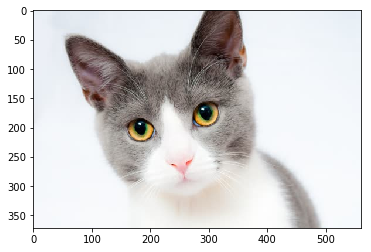

In [3]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [4]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [5]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

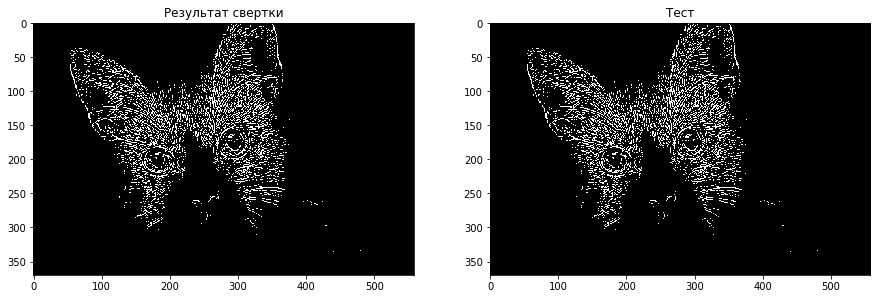

In [6]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_01.pth')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [7]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


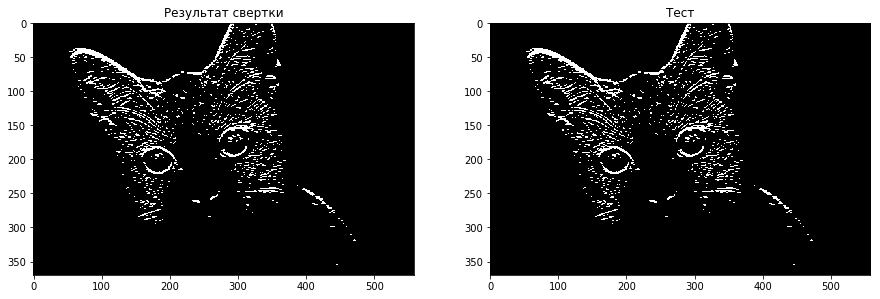

In [8]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_02.pth')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [9]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


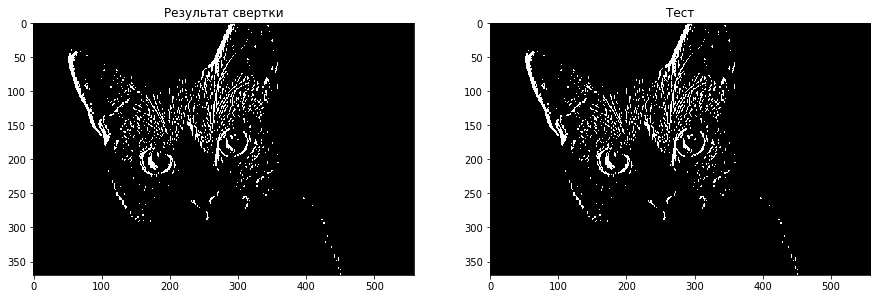

In [10]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_03.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])


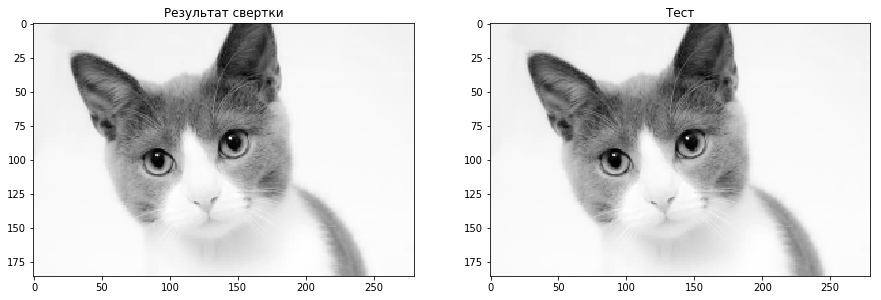

In [11]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_05.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_05.pth')
assert o_image.size() == torch.Size([186, 280]), 'Размер выходного изображения не совпадает с размером теста'
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 1, padding 1

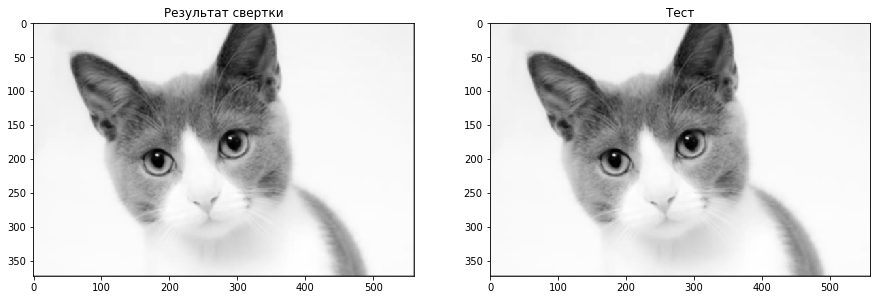

In [12]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(1,1), padding=(1,1))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_04.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_04.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 2, padding 2

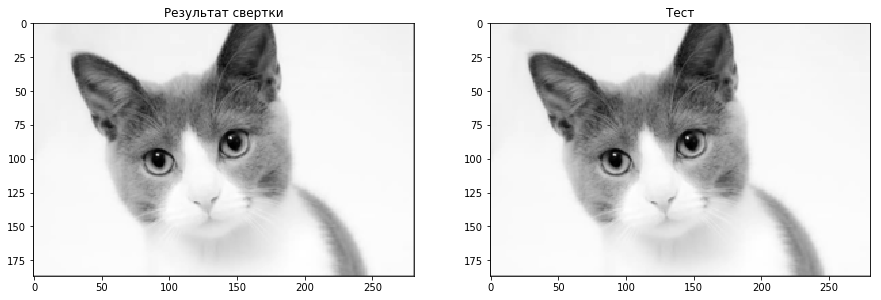

In [13]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2), padding=(2,2))
o_image /= 4 # усредняем
test_conv(o_image, './data/kernel_06.pth')

### Ядро свертки с гаусовым распределением

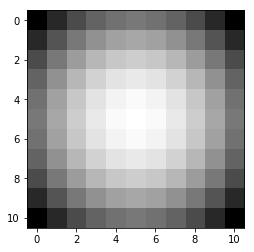

In [14]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

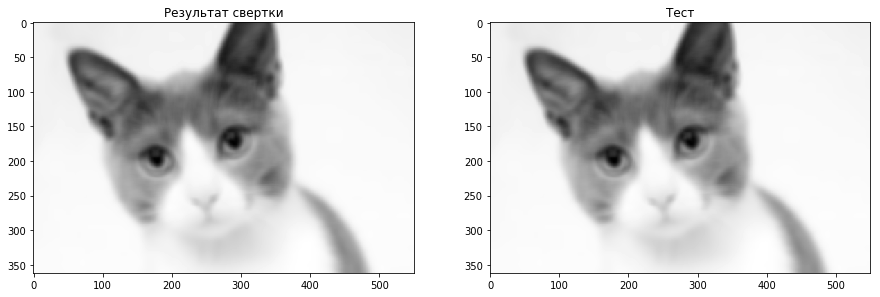

In [15]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
test_conv(o_image, './data/kernel_07.pth', False)

# Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - \mu}{ \sqrt{\sigma^2 + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя \ в \ режиме\ тренировки
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \\ параметры считаются в процессе тренировки
\gamma, b $ - обучаемые параметры параметры.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй (компонентом векторов)

Нужные функции
```python
import torch
torch.zeros - создать тензор заполненный нулями
torch.ones - создать тензор заполненный единицами
torch.Tensor - создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  - среднее и дисперсия
x.uniform_ - заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) - разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1
x.unsqueeze(dim) - добавить размерность в тензор
x.squeeze - убрать размерность

```

### <font color=red>Важно</font> 
Код батч нормализации должен быть максимально простым, _циклы_ в нем не нужны. Используйте встроенные функции torch view, mean, var, unsqueeze, expand_as

In [16]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        self.in_channels=in_channels
        self.afine=afine
        self.beta=beta
        self.epsilon=epsilon
        self.gamma=torch.ones([1,in_channels,1,1],dtype=torch.float).uniform_()
        self.bias=torch.zeros([1,in_channels,1,1],dtype=torch.float)
        self.runing_mean=torch.zeros([1,in_channels,1,1],dtype=torch.float)
        self.runing_var=torch.ones([1,in_channels,1,1],dtype=torch.float)
        self.training = True

#         pass
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """
#         x=x.unsqueeze(0)
#         print(x.shape)
        batch,chanels,h,w=x.shape
#         mean=torch.mean(x,())
#         x=(x-torch.mean(x,(0,2,3),keepdim=True))/torch.sqrt(torch.pow(torch.mean(x,(0,2,3),keepdim=True)\
#                         *(batch*h*w)/(batch*h*w-1),2)+self.epsilon)
        x=x.float()
        current_mean=x.view(batch,chanels,h*w).permute(1,0,2).contiguous().view(chanels,batch*h*w).\
                        mean(dim=1,keepdim=True).reshape(1,chanels,1,1)
        current_var=x.view(batch,chanels,h*w).permute(1,0,2).contiguous().view(chanels,batch*h*w).\
                        var(dim=1,keepdim=True).reshape(1,chanels,1,1)

#         current_mean=torch.mean(x,(0,2,3),keepdim=True)
#         current_var=torch.mean(torch.pow(x-current_mean,2),(0,2,3),keepdim=True)
        if self.training:
           # находимся в режиме обучения
            self.runing_mean=self.runing_mean*self.beta+(1-self.beta)*current_mean
            self.runing_var=self.runing_var*self.beta+(1-self.beta)*current_var
            x_norm=(x-current_mean)/torch.sqrt(current_var+self.epsilon)
        else:
             x_norm=((x-self.runing_mean)/torch.sqrt(self.runing_var+self.epsilon))
        if self.afine:
            return x_norm*self.gamma+self.bias
        return x_norm

### Проверяем работу батч нормадлизации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


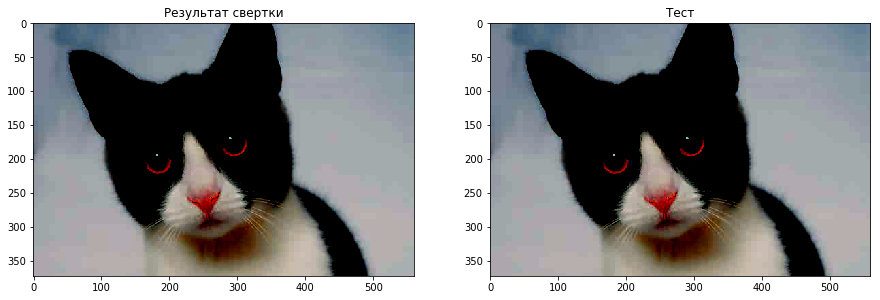

In [17]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
# print(o_image.shape)
o_image = o_image.squeeze()

# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
assert bn.runing_mean.size()[1] == 3 and bn.runing_var.size()[1] == 3,  "Размерности  runing_mean & runing_var должны совпадать с количеством входных каналов"
# assert bn.runing_mean[0] != bn.runing_mean[1],  "Странно, что у вас совпадают значения средних по каналам"
test_conv(o_image, './data/bn_01.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


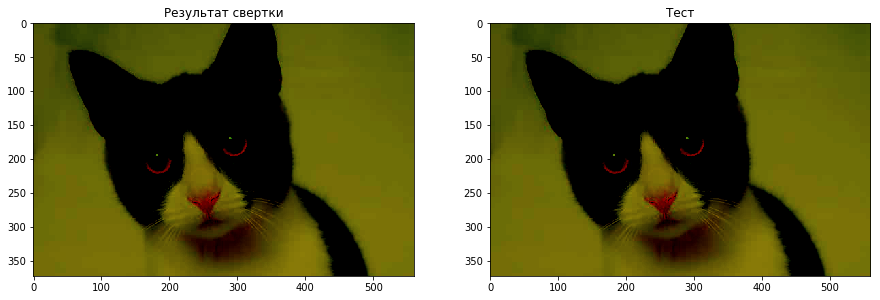

In [18]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
# Поэтому, чтобы получить детерменированный результат устанавливаем seed
# !!! Если Вы делаете перезапуск последующих тестов по BN, то их нужно делать с этого места, 
# иначе тесты могут не проходить.
torch.manual_seed(999)

bn = BatchNorm2d(3, afine=True)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_02.pth')
#print (o_image.size())

### Проверим как реализация работает на большом сете картинок
Цель проверить расчет running_mean and running_var, эти переменные мы расчитываем в режиме тренировки

In [19]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [20]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

c:\users\aleksandr\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
c:\users\aleksandr\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


(70000, 1, 28, 28)


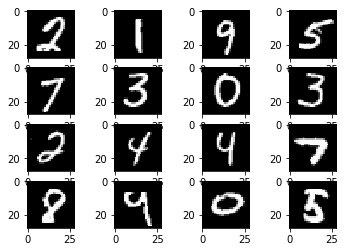

In [21]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются скользящее среднее значение в процессе тренировки

In [22]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    np.random.seed(999)
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.runing_mean ] 
            var_curve +=  [ bn.runing_var ]
    return mean_curve, var_curve

In [23]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

BN beta=09


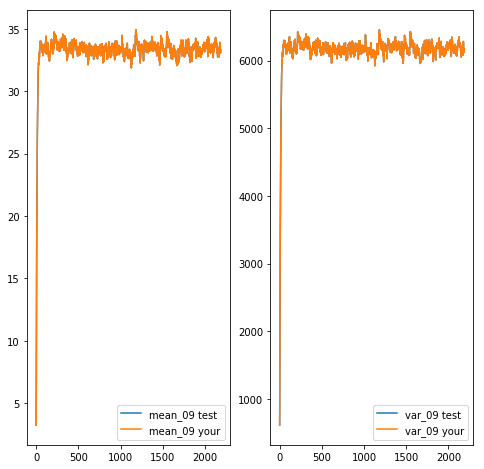

In [24]:
print ("BN beta=09")
test_bn_plots(mean_curve_09, var_curve_09, '09')

BN beta=099


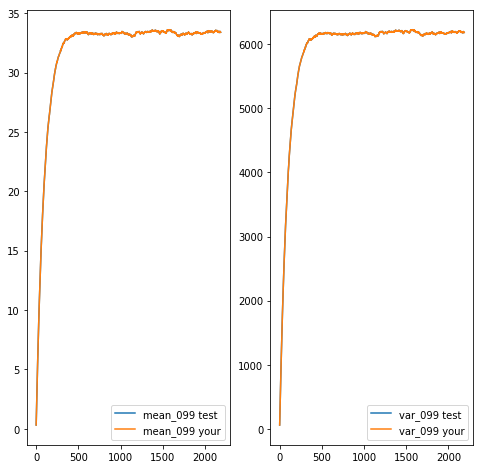

In [25]:
print ("BN beta=099")
test_bn_plots(mean_curve_099, var_curve_099, '099')

BN beta=05


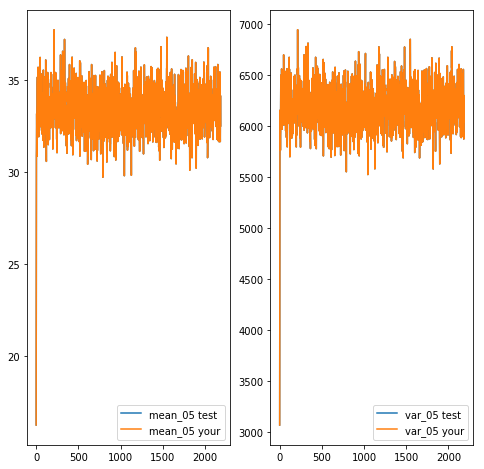

In [26]:
print ("BN beta=05")
test_bn_plots(mean_curve_05, var_curve_05, '05')

Смотрим какие значения средних и дисперсий у нас получились

In [27]:
print ("Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed")
assert int(bn_09.runing_mean[0]) == 33
assert int(bn_099.runing_mean[0]) == 33
assert int(bn_05.runing_mean[0]) == 32
assert int(bn_09.runing_var[0]) == 6136
assert int(bn_099.runing_var[0]) == 6180
assert int(bn_05.runing_var[0]) == 6038
print ('ok')

Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed
ok


Посмотрим как повлияла батч нормализация на изображения

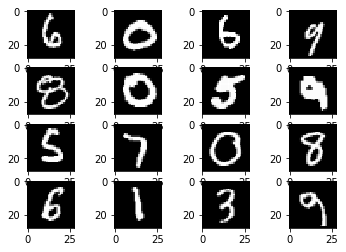

In [28]:
n=4
bn = bn_09
bn.train(False) # эмулируем режим тестирования
np.random.seed(666)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    x=x.reshape(1,x.shape[0],x.shape[1])
#     print("new_size={}".format(x.shape))
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    # загрузим сохраненный тестовый тензор 
    t_I = torch.load('./data/bn_minst_%2d.pth'%i)
    # проверим, что нормализованный и тестовый тензор совпадают 
    assert (I == t_I).all(), "Что-то не так нормализованный тензор и тестовый не совпадают"
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), построить графики для различных параметров для каждого алгоритма, сделать выводы о скорости сходимости


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$


In [29]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] 
            eps = group['eps']
            lr=group['lr']
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                        
                # запоминаем шаг
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                # TODO
                exp_avg=exp_avg*beta1+(1-beta1)*grad
                exp_avg_sq=exp_avg_sq*beta2+(1-beta2)*torch.pow(grad,2)
                m_hat=exp_avg/(1-beta1**state['step'])
                v_hat=exp_avg_sq/(1-beta2**state['step'])
                step_size=lr*np.sqrt(1-beta2**state['step'])/(1-beta1**state['step'])
                # обновляем веса в p.data, 
                # TODO
#                 p.data-=lr*m_hat/torch.sqrt(v_hat+eps)
                p.data-=step_size*exp_avg/torch.sqrt(exp_avg_sq+eps)
                
        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [40]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr=group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                d_p = p.grad.data
                
                if beta != 0:
                    # тут добавляем момент если он указан
                    # todo
                    state = self.state[p]

                    # если параметры мы еще не записали инициализируем их значения
                    if 'momentum' not in state:
                        momentum=state['momentum'] = torch.zeros_like(p.data)
#                         momentum=momentum*beta+d_p
#                         d_p=momentum
#                     else: 
                    momentum = state['momentum']
                    momentum=beta*momentum-(1-beta)*d_p
                    d_p=-momentum

                p.data-=d_p

#         print(loss)
        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [41]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [42]:
USE_CUDA=True

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        # добавляем бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))            
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        # добавляем бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))
        # Линейный слой классификатора
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

## Функция обучения модели

In [44]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
#             print(loss[0])
            loss_acc += float( loss )
            loss.backward()
            optimizer.step()  
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
#         print(type(avg_epoch_loss),avg_epoch_loss)
#         assert not np.isnan(avg_epoch_loss),"hz"
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [45]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.2902637353643032
Do epoch 1 with loss 0.16732775894171253
Do epoch 2 with loss 0.15963386517030004
Do epoch 3 with loss 0.1491283009558657
Do epoch 4 with loss 0.14552768895246693
Do epoch 5 with loss 0.14216676128540182
Do epoch 6 with loss 0.13505634117682447
Do epoch 7 with loss 0.13424896071041126
Do epoch 8 with loss 0.12936965782564963
Do epoch 9 with loss 0.1257035216826743
Do epoch 10 with loss 0.12347447710340842
Do epoch 11 with loss 0.11786498113356064
Do epoch 12 with loss 0.1158016840235305
Do epoch 13 with loss 0.11399749719257163
Do epoch 14 with loss 0.11132111628277966
Do epoch 15 with loss 0.1097872817814759
Do epoch 16 with loss 0.10779810508787223
Do epoch 17 with loss 0.10464967839729857
Do epoch 18 with loss 0.10303360090225212
Do epoch 19 with loss 0.10163408068826768


## SGD с моментом

In [46]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.12150945214816136
Do epoch 1 with loss 0.051719169758829175
Do epoch 2 with loss 0.040133385453586114
Do epoch 3 with loss 0.03498201394154702
Do epoch 4 with loss 0.028813026256085967
Do epoch 5 with loss 0.026771422528381154
Do epoch 6 with loss 0.02449792500195244
Do epoch 7 with loss 0.022140657869059034
Do epoch 8 with loss 0.020611564875344025
Do epoch 9 with loss 0.018972993629486744
Do epoch 10 with loss 0.016959580585571746
Do epoch 11 with loss 0.016517425447388986
Do epoch 12 with loss 0.014976804274563164
Do epoch 13 with loss 0.013784091836194988
Do epoch 14 with loss 0.012299386086900538
Do epoch 15 with loss 0.0119625132208989
Do epoch 16 with loss 0.010975980477950101
Do epoch 17 with loss 0.010671258013598386
Do epoch 18 with loss 0.009626762826501586
Do epoch 19 with loss 0.009183690786552472


## Adam

In [47]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.22146663560809257
Do epoch 1 with loss 0.0741880006260342
Do epoch 2 with loss 0.06442372271280938
Do epoch 3 with loss 0.05841826258808933
Do epoch 4 with loss 0.05333063097702187
Do epoch 5 with loss 0.051252081670006715
Do epoch 6 with loss 0.04712993705114601
Do epoch 7 with loss 0.04614759276433246
Do epoch 8 with loss 0.04383758698416781
Do epoch 9 with loss 0.044511024953024975
Do epoch 10 with loss 0.042980564311044536
Do epoch 11 with loss 0.04095893065352717
Do epoch 12 with loss 0.04097195613531419
Do epoch 13 with loss 0.03829704663172453
Do epoch 14 with loss 0.03973225016652802
Do epoch 15 with loss 0.038239158557112164
Do epoch 16 with loss 0.0362804484356469
Do epoch 17 with loss 0.037066704288268124
Do epoch 18 with loss 0.03748289089961634
Do epoch 19 with loss 0.036741239271264235


In [ ]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(21, net, optimizer)

# Кривые обучения

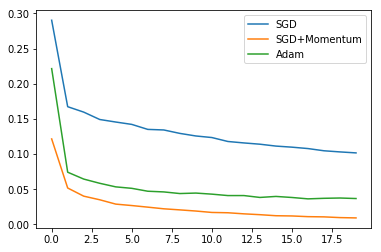

In [48]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы
Тут нужно написать выводы по сравнению скорости сходимлости алгоритмов SGD, SGD + Momentum, ADAM для различных праметров
1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
2. beta - для SGD + momentum (0,9, 0,99, 0,5) для лучшего графика в пункте 1.
3. beta1, beta2 - для ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего графика в пункте 1.

TODO

## lr==0.01

## SGD+momentum

In [104]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.12281844252571429
Do epoch 1 with loss 0.052651199842213385
Do epoch 2 with loss 0.04001877500509965
Do epoch 3 with loss 0.0338649061488462
Do epoch 4 with loss 0.029297414429530086
Do epoch 5 with loss 0.02684422330969155
Do epoch 6 with loss 0.024383428213146107
Do epoch 7 with loss 0.021915299319681315
Do epoch 8 with loss 0.019870203279663996
Do epoch 9 with loss 0.01801874629631945
Do epoch 10 with loss 0.0164233360713783
Do epoch 11 with loss 0.015244805930709534
Do epoch 12 with loss 0.014730170614434858
Do epoch 13 with loss 0.013218500057365669
Do epoch 14 with loss 0.012814169377429222
Do epoch 15 with loss 0.011905463167969145
Do epoch 16 with loss 0.011146948453520987
Do epoch 17 with loss 0.009165296042325239
Do epoch 18 with loss 0.009583904034452565
Do epoch 19 with loss 0.00907902466239698
Do epoch 20 with loss 0.0077156005968064215


## SGD

In [105]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd_momentum = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.24663528562559622
Do epoch 1 with loss 0.14204135816842386
Do epoch 2 with loss 0.12508330209701096
Do epoch 3 with loss 0.11727510028824067
Do epoch 4 with loss 0.10874754581200133
Do epoch 5 with loss 0.10222368409059121
Do epoch 6 with loss 0.1169797465763901
Do epoch 7 with loss 0.13369362416349703
Do epoch 8 with loss 0.12264266191114287
Do epoch 9 with loss 0.12004887646172327
Do epoch 10 with loss 0.11614758771033826
Do epoch 11 with loss 0.11002391889507387
Do epoch 12 with loss 0.11065085439729429
Do epoch 13 with loss 0.10443361131129442
Do epoch 14 with loss 0.17006829309787824
Do epoch 15 with loss 0.16258904216943074
Do epoch 16 with loss 0.14540149797151009
Do epoch 17 with loss 0.13326097455575797
Do epoch 18 with loss 0.13010680991313095
Do epoch 19 with loss 0.1252222627019795
Do epoch 20 with loss 0.12251841684673058


## Adam

In [60]:
learning_rate = 1e-2
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.16581843299582552
Do epoch 1 with loss 0.11082738825977258
Do epoch 2 with loss 0.10322244367917814
Do epoch 3 with loss 0.10102010252925976
Do epoch 4 with loss 0.08751459872826191
Do epoch 5 with loss 0.08564749644889535
Do epoch 6 with loss 0.08011736834926805
Do epoch 7 with loss 0.08250610284408479
Do epoch 8 with loss 0.077925716953077
Do epoch 9 with loss 0.08474618613474653
Do epoch 10 with loss 0.07558011594405172
Do epoch 11 with loss 0.07374055929580779
Do epoch 12 with loss 0.07216151032101144
Do epoch 13 with loss 0.06655698417799627
Do epoch 14 with loss 0.06872089932811931
Do epoch 15 with loss 0.07078806559244792
Do epoch 16 with loss 0.06732395614289126
Do epoch 17 with loss 0.06230386621504
Do epoch 18 with loss 0.065015661809125
Do epoch 19 with loss 0.06153176198225889


## lr==0.001

## SGD+momentum

In [106]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.12159714846270074
Do epoch 1 with loss 0.055653152840018656
Do epoch 2 with loss 0.044620366451071994
Do epoch 3 with loss 0.03797679092304097
Do epoch 4 with loss 0.03244034314011132
Do epoch 5 with loss 0.02897913095459962
Do epoch 6 with loss 0.026460312102475448
Do epoch 7 with loss 0.023753307330510252
Do epoch 8 with loss 0.021908129432128345
Do epoch 9 with loss 0.019697742186619585
Do epoch 10 with loss 0.017305059463235413
Do epoch 11 with loss 0.016887685307014136
Do epoch 12 with loss 0.015166528996507708
Do epoch 13 with loss 0.014486683071831562
Do epoch 14 with loss 0.013651201989506825
Do epoch 15 with loss 0.012389435079825976
Do epoch 16 with loss 0.012085947313290183
Do epoch 17 with loss 0.010568243707349217
Do epoch 18 with loss 0.009690475735726506
Do epoch 19 with loss 0.009646472862227954
Do epoch 20 with loss 0.00909984220802157


## SGD

In [51]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd_momentum = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.21099338147007388
Do epoch 1 with loss 0.13245242324440132
Do epoch 2 with loss 0.09673933794182842
Do epoch 3 with loss 0.08546831165485094
Do epoch 4 with loss 0.07743267762160869
Do epoch 5 with loss 0.07397671636989468
Do epoch 6 with loss 0.06883771675985918
Do epoch 7 with loss 0.06679567452102804
Do epoch 8 with loss 0.06478968871460149
Do epoch 9 with loss 0.06284024300344142
Do epoch 10 with loss 0.060999120421670154
Do epoch 11 with loss 0.05788486663151616
Do epoch 12 with loss 0.05645681522483416
Do epoch 13 with loss 0.05618584251084936
Do epoch 14 with loss 0.05556068954726142
Do epoch 15 with loss 0.05417200488944985
Do epoch 16 with loss 0.05326564692107302
Do epoch 17 with loss 0.05011935390031223
Do epoch 18 with loss 0.04988215420144739
Do epoch 19 with loss 0.05036761720034975
Do epoch 20 with loss 0.04839381813376147


## lr=0.0001

## SGD+momentum

In [52]:
learning_rate = 1e-4
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.12863238380347206
Do epoch 1 with loss 0.05559746840322296
Do epoch 2 with loss 0.043824638423578456
Do epoch 3 with loss 0.03580753760055477
Do epoch 4 with loss 0.03210223247103349
Do epoch 5 with loss 0.028358251610996518
Do epoch 6 with loss 0.024797934788408266
Do epoch 7 with loss 0.023038830030683955
Do epoch 8 with loss 0.021114559408922855
Do epoch 9 with loss 0.018563650562085133
Do epoch 10 with loss 0.01811640169326715
Do epoch 11 with loss 0.01635076343045695
Do epoch 12 with loss 0.014885508890123633
Do epoch 13 with loss 0.01436530891337458
Do epoch 14 with loss 0.01276574070575197
Do epoch 15 with loss 0.011580078185940094
Do epoch 16 with loss 0.011105771475885904
Do epoch 17 with loss 0.009783327800937587
Do epoch 18 with loss 0.009829890134539514
Do epoch 19 with loss 0.009021398114405868
Do epoch 20 with loss 0.007669638925809865


## SGD

In [55]:
learning_rate = 1e-4
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd_momentum = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.22482371528193892
Do epoch 1 with loss 0.12324289518149138
Do epoch 2 with loss 0.14493170941344777
Do epoch 3 with loss 0.12351512051454461
Do epoch 4 with loss 0.10650640364291737
Do epoch 5 with loss 0.11494961324747044
Do epoch 6 with loss 0.09615126875270487
Do epoch 7 with loss 0.09142239295733155
Do epoch 8 with loss 0.09209006273915465
Do epoch 9 with loss 0.08795693664925253
Do epoch 10 with loss 0.08752197306901284
Do epoch 11 with loss 0.08806436017639407
Do epoch 12 with loss 0.0821428680745608
Do epoch 13 with loss 0.07736219899753594
Do epoch 14 with loss 0.0767816912278935
Do epoch 15 with loss 0.07657639142662409
Do epoch 16 with loss 0.07524862125427362
Do epoch 17 with loss 0.0775074033934502
Do epoch 18 with loss 0.0735588714030708
Do epoch 19 with loss 0.07552969006708238
Do epoch 20 with loss 0.07144754872264304


## Adam

In [54]:
learning_rate = 1e-4
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.6563906301899716
Do epoch 1 with loss 0.11566934549084906
Do epoch 2 with loss 0.08420245857695548
Do epoch 3 with loss 0.07178228337251273
Do epoch 4 with loss 0.0639968422323697
Do epoch 5 with loss 0.05849362240025154
Do epoch 6 with loss 0.053679678393217
Do epoch 7 with loss 0.05042275239955796
Do epoch 8 with loss 0.04858372720562273
Do epoch 9 with loss 0.04682043517731508
Do epoch 10 with loss 0.04565628162518341
Do epoch 11 with loss 0.044140574045796126
Do epoch 12 with loss 0.042946542132429516
Do epoch 13 with loss 0.04219309521637172
Do epoch 14 with loss 0.04026581241379168
Do epoch 15 with loss 0.039333759511939785
Do epoch 16 with loss 0.0379313143846593
Do epoch 17 with loss 0.03705322377257659
Do epoch 18 with loss 0.037512831236599896
Do epoch 19 with loss 0.03606166793812777


проведя ряд экспериментов стало понятно что градиентный спуск и градиентный спуск с моментом очень сильно зависит от learning rate, таким образом лучшее значение лосса для SGD получается при значении learning rate=0.001, лучшее значение для SGD+Momentum получилось при значении lr меньше, но значения лоссов схожи и поэтому можно считать lr=0.001

# меньшие значения бет

## SGD+momentum

In [61]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.5)
loss_curve_sgd_momentum = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.12547267148646798
Do epoch 1 with loss 0.05568185487483591
Do epoch 2 with loss 0.04425880128273312
Do epoch 3 with loss 0.03961298140519604
Do epoch 4 with loss 0.03520118130032854
Do epoch 5 with loss 0.031576665330407386
Do epoch 6 with loss 0.0310995499524669
Do epoch 7 with loss 0.027821165877877713
Do epoch 8 with loss 0.026044824793015
Do epoch 9 with loss 0.025132436429631182
Do epoch 10 with loss 0.023685406615840936
Do epoch 11 with loss 0.023178500137374887
Do epoch 12 with loss 0.021156736879954886
Do epoch 13 with loss 0.020116532712861398
Do epoch 14 with loss 0.01866608544346073
Do epoch 15 with loss 0.018626730212840413
Do epoch 16 with loss 0.01833820336885413
Do epoch 17 with loss 0.01758341126358558
Do epoch 18 with loss 0.016322663863827008
Do epoch 19 with loss 0.017276968328332486
Do epoch 20 with loss 0.014747268157050008


## Adam

In [62]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.5, 0.5))
loss_curve_adam = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.25291845135971613
Do epoch 1 with loss 0.09001478188976503
Do epoch 2 with loss 0.07951800638974177
Do epoch 3 with loss 0.07197141462011211
Do epoch 4 with loss 0.06856800444768235
Do epoch 5 with loss 0.06352904500294124
Do epoch 6 with loss 0.06318507458338413
Do epoch 7 with loss 0.06064979006397054
Do epoch 8 with loss 0.05864339818897779
Do epoch 9 with loss 0.057713277491467915
Do epoch 10 with loss 0.05459426536263534
Do epoch 11 with loss 0.05432868516221676
Do epoch 12 with loss 0.053846466524937846
Do epoch 13 with loss 0.052091115786705486
Do epoch 14 with loss 0.052697379239138586
Do epoch 15 with loss 0.05146618962124378
Do epoch 16 with loss 0.05248590599307743
Do epoch 17 with loss 0.05160735609545575
Do epoch 18 with loss 0.05419678637901833
Do epoch 19 with loss 0.05304211397175381
Do epoch 20 with loss 0.053474870183776384


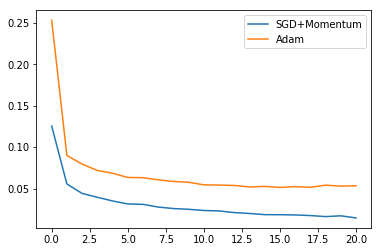

In [63]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

# большие значения бет

## SGD+momentum

In [101]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.999)
loss_curve_sgd_momentum = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.13095139210961101
Do epoch 1 with loss 0.05663098267117318
Do epoch 2 with loss 0.04531280235457649
Do epoch 3 with loss 0.03926600503918783
Do epoch 4 with loss 0.03511925653188699
Do epoch 5 with loss 0.030518799096986373
Do epoch 6 with loss 0.030022720618503085
Do epoch 7 with loss 0.028023879050145587
Do epoch 8 with loss 0.025609449202822505
Do epoch 9 with loss 0.024751791826764034
Do epoch 10 with loss 0.02186605309753261
Do epoch 11 with loss 0.02133941652094004
Do epoch 12 with loss 0.021092757882459227
Do epoch 13 with loss 0.01849002839088658
Do epoch 14 with loss 0.019012074459345853
Do epoch 15 with loss 0.017429539829042877
Do epoch 16 with loss 0.01732340864888271
Do epoch 17 with loss 0.016762147646927104
Do epoch 18 with loss 0.015270377505463338
Do epoch 19 with loss 0.014517133121191773
Do epoch 20 with loss 0.014008495185028542


## Adam

In [64]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.99, 0.99))
loss_curve_adam = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.737111131469436
Do epoch 1 with loss 0.18140276664272667
Do epoch 2 with loss 0.12775327976977016
Do epoch 3 with loss 0.10459581870887179
Do epoch 4 with loss 0.09175270704521019
Do epoch 5 with loss 0.08373532110717016
Do epoch 6 with loss 0.07724849354419525
Do epoch 7 with loss 0.07317245499859894
Do epoch 8 with loss 0.0687406981269355
Do epoch 9 with loss 0.06579979642319472
Do epoch 10 with loss 0.06386075226422254
Do epoch 11 with loss 0.06172696896541266
Do epoch 12 with loss 0.05938569628380181
Do epoch 13 with loss 0.057669503535099316
Do epoch 14 with loss 0.056987636155824875
Do epoch 15 with loss 0.055607933021322144
Do epoch 16 with loss 0.0540248622183501
Do epoch 17 with loss 0.05320858105056407
Do epoch 18 with loss 0.05245089787133055
Do epoch 19 with loss 0.05116667843431875
Do epoch 20 with loss 0.050587981217083015


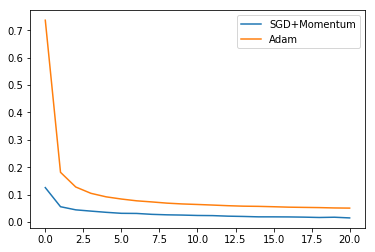

In [65]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

лучшим значением beta при котором была лучшая скорость схожеения sgd+momentum было beta=0.9 и скорости схождения выглядели слудующим образом\\
$$ \beta =0.9>\beta=0.5>\beta=0.99$$


## Adam

In [67]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.99))
loss_curve_adam_09_099 = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.2232777327861233
Do epoch 1 with loss 0.07652374860844657
Do epoch 2 with loss 0.06535981777437103
Do epoch 3 with loss 0.05973737404452212
Do epoch 4 with loss 0.055775144626737785
Do epoch 5 with loss 0.05125415624959533
Do epoch 6 with loss 0.05036218274277424
Do epoch 7 with loss 0.048815018410109254
Do epoch 8 with loss 0.047821481641046416
Do epoch 9 with loss 0.045446015625279085
Do epoch 10 with loss 0.04412884204203427
Do epoch 11 with loss 0.04205566418459822
Do epoch 12 with loss 0.043476606211163
Do epoch 13 with loss 0.0412796401628687
Do epoch 14 with loss 0.04073529620665527
Do epoch 15 with loss 0.04055693076525751
Do epoch 16 with loss 0.039952038737481516
Do epoch 17 with loss 0.03760935892838564
Do epoch 18 with loss 0.038407303505310145
Do epoch 19 with loss 0.037343545433152575
Do epoch 20 with loss 0.037080993268606484


## Adam

In [68]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.5))
loss_curve_adam_09_05 = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.5841309150811208
Do epoch 1 with loss 0.14695527919989282
Do epoch 2 with loss 0.11037707135973862
Do epoch 3 with loss 0.0954209805679583
Do epoch 4 with loss 0.08621071227947544
Do epoch 5 with loss 0.08097274855603678
Do epoch 6 with loss 0.0766588703486055
Do epoch 7 with loss 0.07399781087134928
Do epoch 8 with loss 0.07016676498102607
Do epoch 9 with loss 0.06863059875460373
Do epoch 10 with loss 0.06680282447563768
Do epoch 11 with loss 0.06453859860568925
Do epoch 12 with loss 0.0634172550335724
Do epoch 13 with loss 0.062473794015292225
Do epoch 14 with loss 0.06047542050487656
Do epoch 15 with loss 0.059789631973950354
Do epoch 16 with loss 0.05960042824415949
Do epoch 17 with loss 0.05846421196409486
Do epoch 18 with loss 0.057448862892991615
Do epoch 19 with loss 0.05764114535121979
Do epoch 20 with loss 0.05556142586357909


## Adam

In [69]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.99, 0.9))
loss_curve_adam_099_09 = fit_net(21, net, optimizer)

Do epoch 0 with loss 1.156200993766946
Do epoch 1 with loss 0.42210065393917734
Do epoch 2 with loss 0.24286429485400682
Do epoch 3 with loss 0.18080349465483772
Do epoch 4 with loss 0.14916469171348573
Do epoch 5 with loss 0.13022796736555758
Do epoch 6 with loss 0.11776375377599267
Do epoch 7 with loss 0.10858459875607632
Do epoch 8 with loss 0.10153712473969836
Do epoch 9 with loss 0.09554093862893541
Do epoch 10 with loss 0.09068400291176654
Do epoch 11 with loss 0.08683335400903176
Do epoch 12 with loss 0.08390325634894874
Do epoch 13 with loss 0.08129825543528776
Do epoch 14 with loss 0.07838805021899554
Do epoch 15 with loss 0.07580452831738825
Do epoch 16 with loss 0.07373078751356894
Do epoch 17 with loss 0.07204179762158701
Do epoch 18 with loss 0.07022600600203804
Do epoch 19 with loss 0.06946509645908566
Do epoch 20 with loss 0.0677654028865481


## Adam

In [70]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.5, 0.99))
loss_curve_adam_05_099 = fit_net(21, net, optimizer)

Do epoch 0 with loss 0.18062631895056205
Do epoch 1 with loss 0.08282693199878094
Do epoch 2 with loss 0.07552286724985381
Do epoch 3 with loss 0.07015409183981869
Do epoch 4 with loss 0.06760030126375426
Do epoch 5 with loss 0.06734073614496372
Do epoch 6 with loss 0.06649379529634676
Do epoch 7 with loss 0.06630103578292784
Do epoch 8 with loss 0.06384214637592388
Do epoch 9 with loss 0.06681668491302477
Do epoch 10 with loss 0.06460656060112847
Do epoch 11 with loss 0.06687585632714933
Do epoch 12 with loss 0.06838572990093048
Do epoch 13 with loss 0.07060434003916297
Do epoch 14 with loss 0.07529933843974605
Do epoch 15 with loss 0.07314325305605567
Do epoch 16 with loss 0.07436653943055288
Do epoch 17 with loss 0.07506997169944649
Do epoch 18 with loss 0.07861544936554694
Do epoch 19 with loss 0.08051864665885684
Do epoch 20 with loss 0.07952422816621478


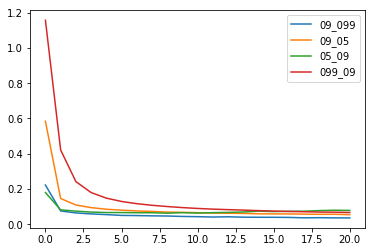

In [82]:
plt.plot(loss_curve_adam_09_099,label='09_099')
plt.plot(loss_curve_adam_09_05, label='09_05' )
plt.plot(loss_curve_adam_05_099, label='05_09' )
plt.plot(loss_curve_adam_099_09, label='099_09' )
plt.legend()

из предыдущих графиков было понятно что при значениях $$\beta_1=0.99\, \beta_2=0.99$$ алгоритм не сходился , так же получалось при одновременно маленьких значениях. но если значения отличаются то в результате мы получаем приблизительно равные результаты.т.е. при правильно подобранных значениях lr и beta1!= beta2, мы сможем заглядывать назад(что обеспечивается при первом параметре) и не сильно скакать при обнавлении параметров(что позволяет второй параметр), что обеспечивает лучшую сходимость)